In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
os.path.dirname(sys.executable)
# sys.path.append('/kuacc/users/ckoksal20/COMP547Project/SSuperGAN/')
sys.path.append('/kuacc/users/baristopal20/SSuperGAN/')

In [3]:
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.models import SSuperVAE, SSuperDCGAN
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo

In [10]:
config = read_config(Config.SSUPERDCGAN)
golden_age_config = read_config(Config.GOLDEN_AGE)
model_path = "ckpts/ssuper_dcgan-checkpoint-epoch43.pth"
# N_SAMPLES = 1280 # 50000

In [11]:
net = SSuperDCGAN(
    backbone=config.backbone,
    embed_dim=config.embed_dim,
    latent_dim=config.latent_dim,
    img_size=config.img_size,
    use_lstm=config.use_lstm,
    gen_channels=config.gen_channels,
    local_disc_channels=config.local_disc_channels,
    seq_size=config.seq_size,
    lstm_conv=config.lstm_conv,
    lstm_bidirectional=config.lstm_bidirectional,
    lstm_hidden=config.lstm_hidden,
    lstm_dropout=config.lstm_dropout,
    fc_hidden_dims=config.fc_hidden_dims,
    fc_dropout=config.fc_dropout,
    num_lstm_layers=config.num_lstm_layers,
    masked_first=config.masked_first)

if config.parallel:
    net = nn.DataParallel(net)

net.load_state_dict(torch.load(model_path)['model_state_dict'])
net = net.cuda().eval()

dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                              golden_age_config.sequence_path, 
                              config.panel_size,
                              config.img_size, 
                              augment=False, 
                              mask_val=1, # mask with white color for 1 and black color for 0
                              mask_all=False, # masks faces from all panels and returns all faces
                              return_mask=True,
                              train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              limit_size=-1)

data_loader = DataLoader(dataset, batch_size=1)

Loaded pretrained weights for efficientnet-b5


In [12]:
dl_iter = iter(data_loader)

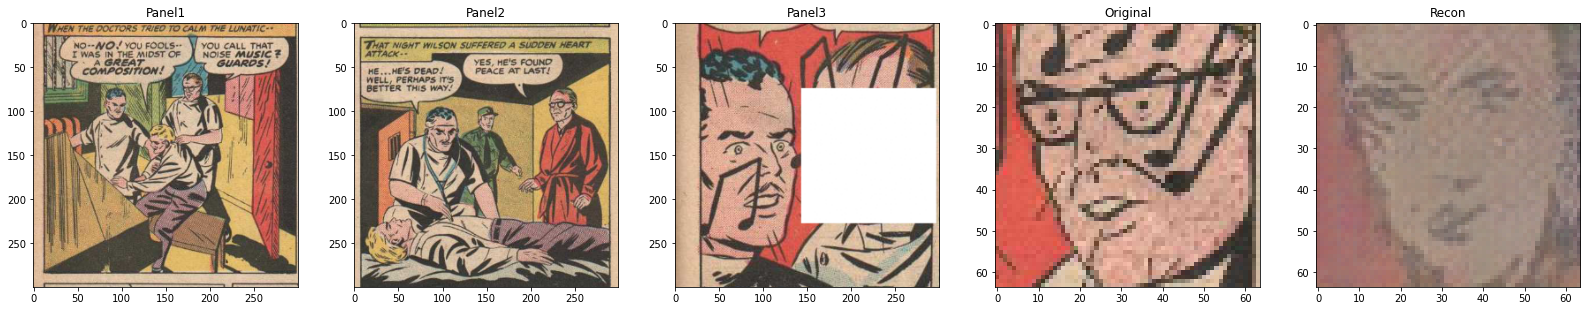

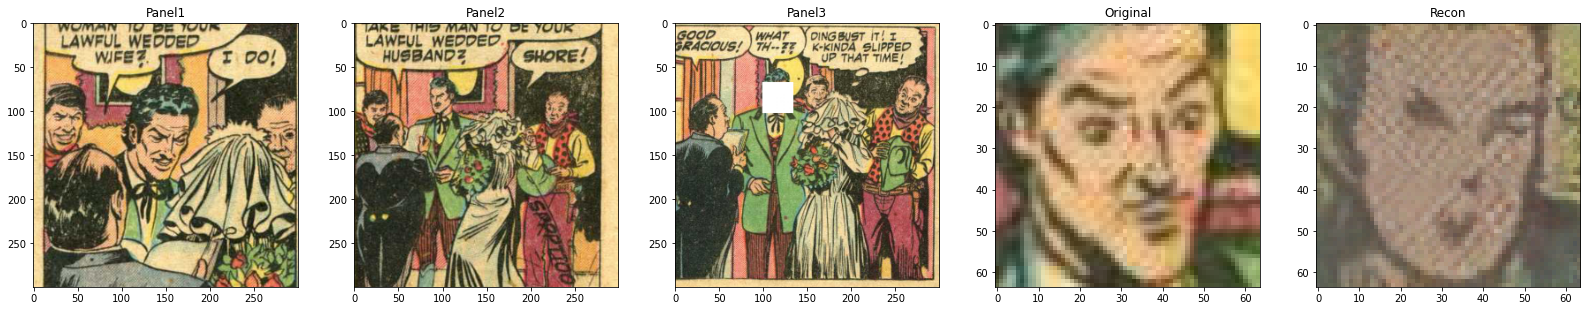

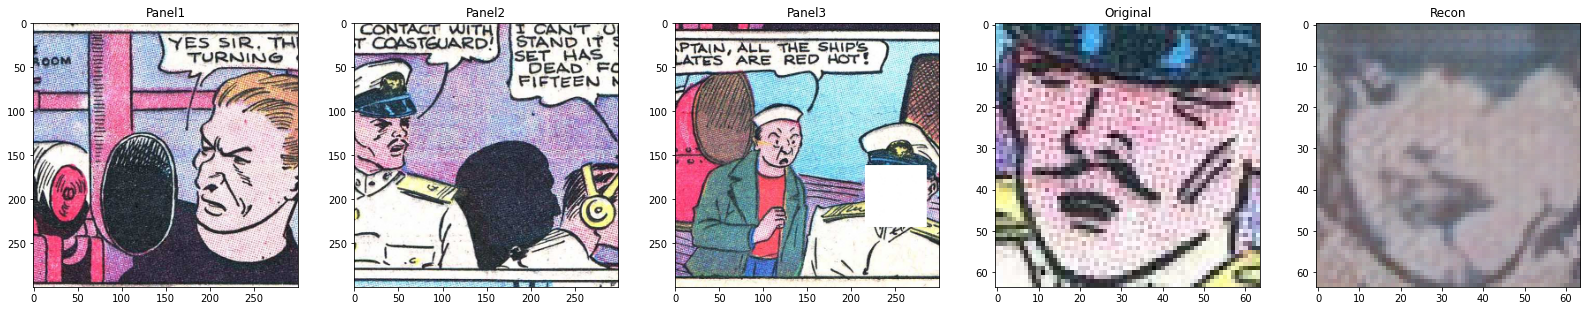

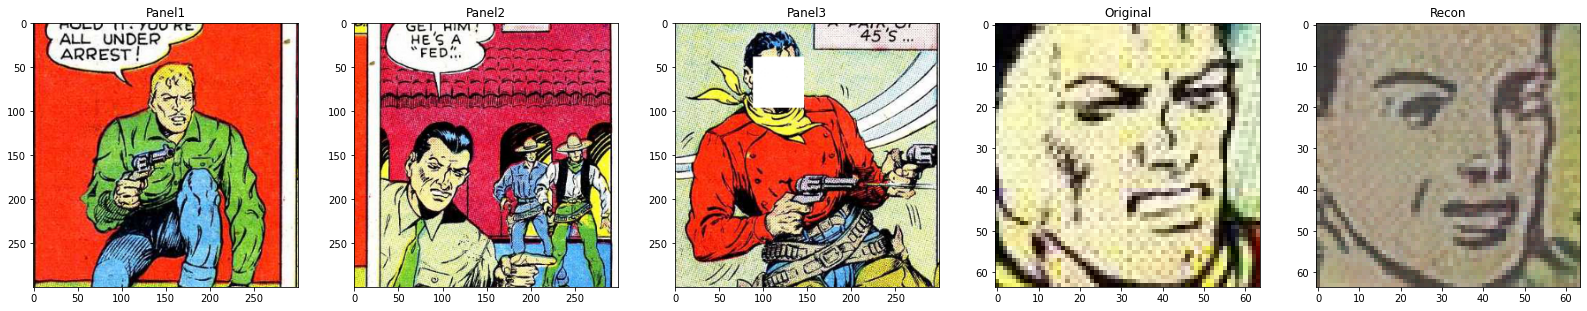

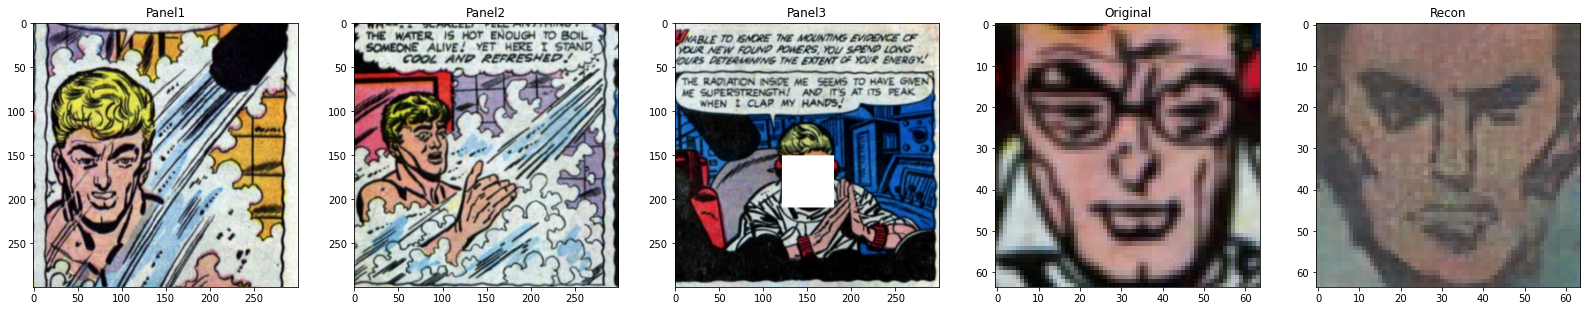

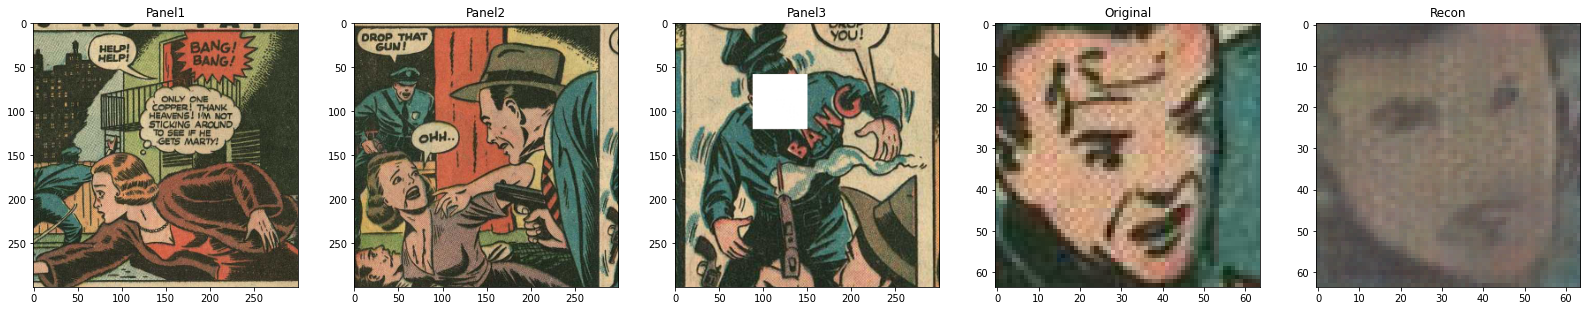

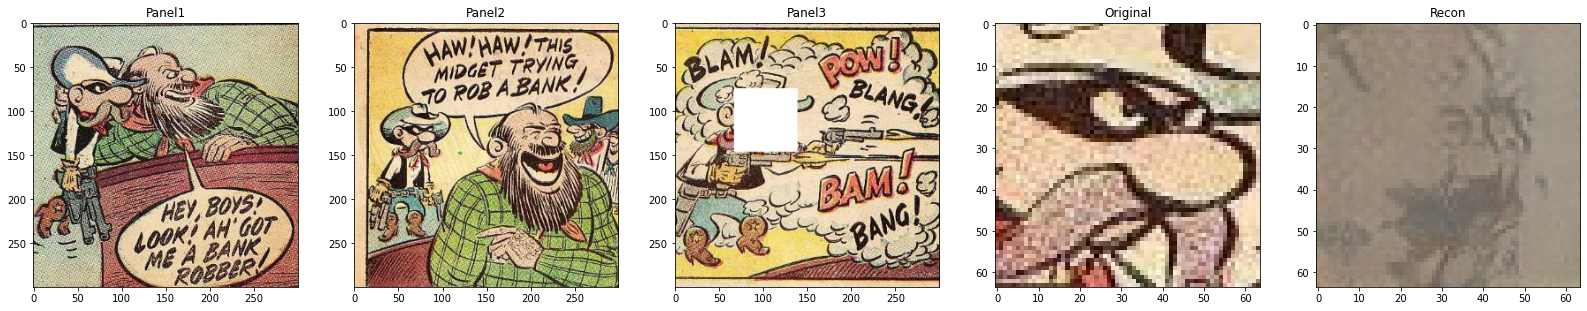

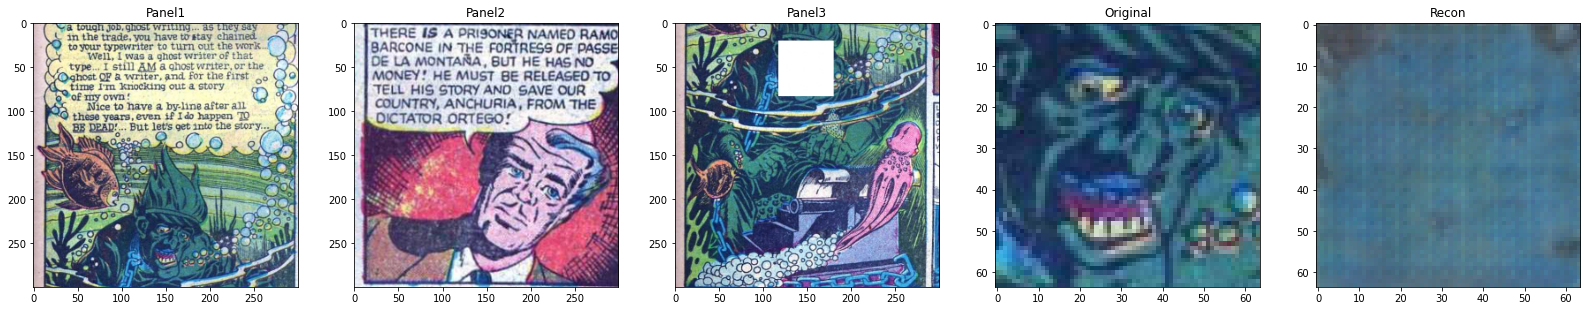

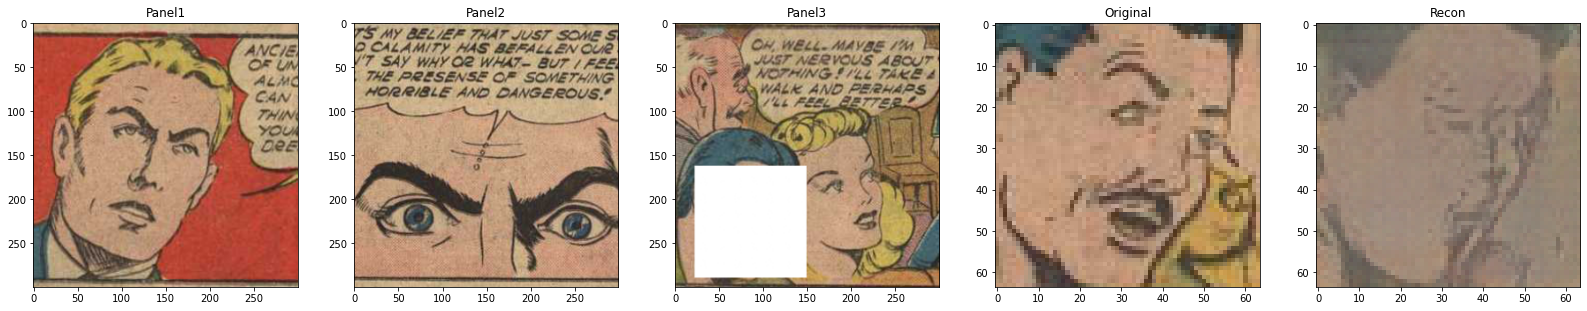

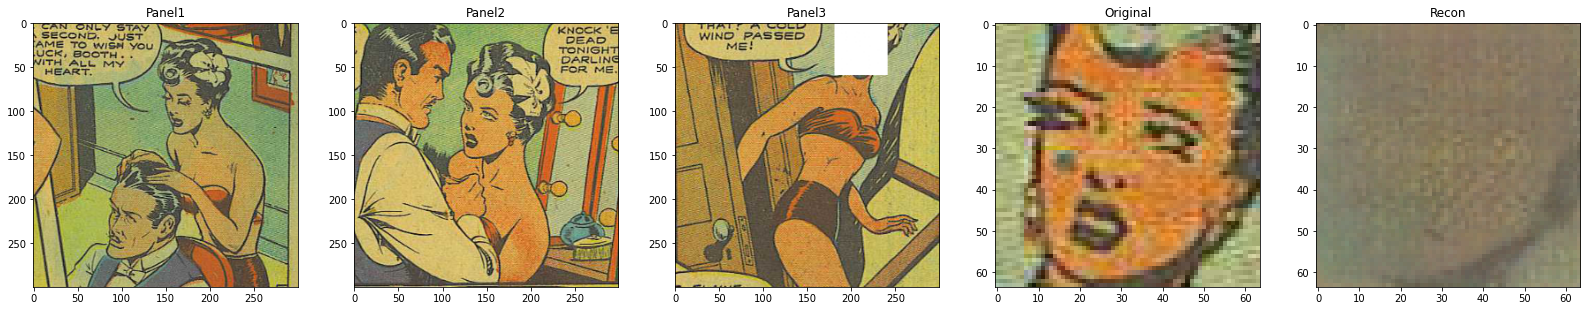

In [13]:
ctr, limit = 0, 10
x_arr = []
y_arr = []
z_arr = []
for _ in range(limit):
    x, y, z = next(dl_iter)
    x_arr.append(x)
    y_arr.append(y)
    z_arr.append(z)
    
    with torch.no_grad():
        mu_z, _ = net(x.cuda(), f="seq_encode")
        mu_z = mu_z.unsqueeze(-1).unsqueeze(-1)
        y_recon = net(mu_z, f="generate")
        
    plot_panels_and_faces(x, y, y_recon)

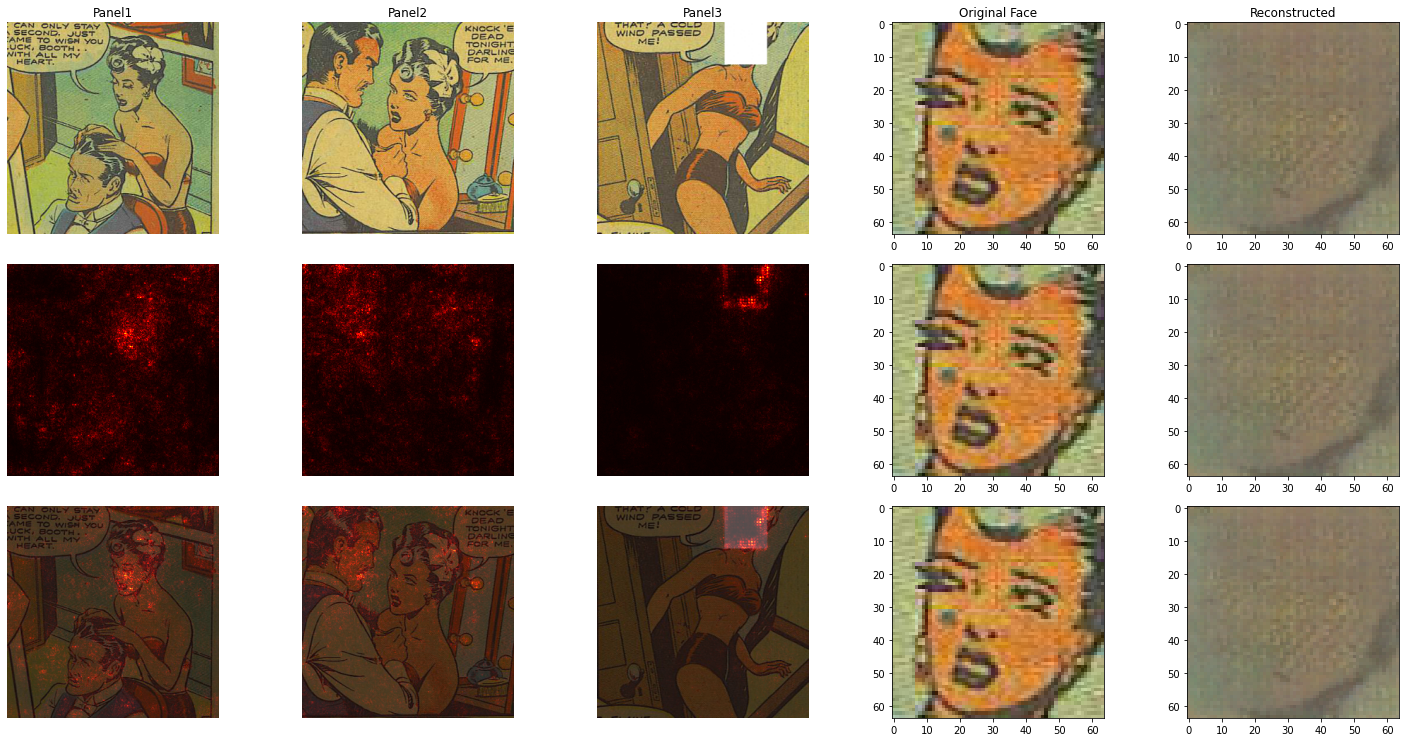

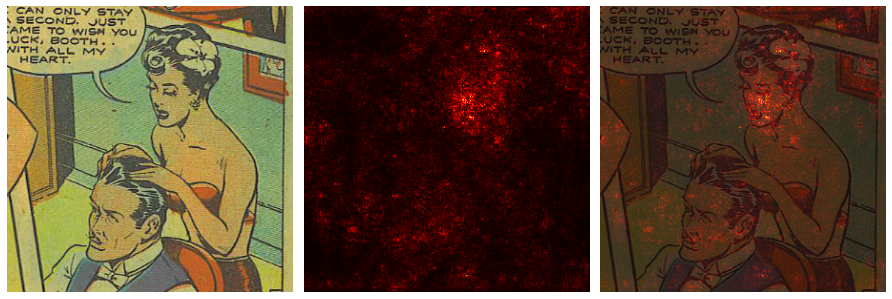

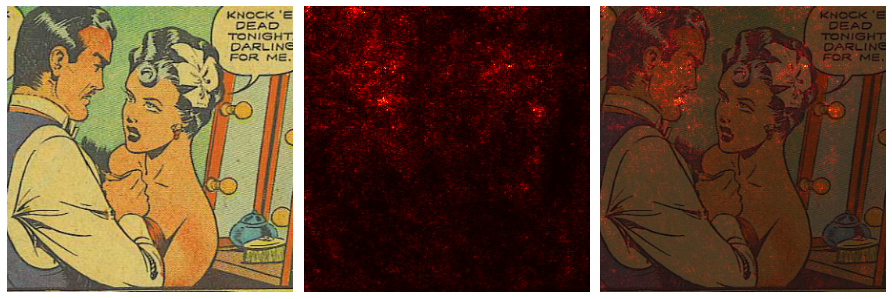

In [15]:
if config.use_lstm:
    net.module.seq_encoder.lstm.train()

x, y, z = x_arr[-1], y_arr[-1], z_arr[-1]
# x, y, z = next(dl_iter)
draw_saliency(net, x, y)

if config.use_lstm:
    net.module.seq_encoder.lstm.eval()

backbone = net.seq_encoder.embedder if not config.parallel else net.module.seq_encoder.embedder
draw_backbone_saliency(backbone, x, 0)
draw_backbone_saliency(backbone, x, 1)

In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained("efficientnet-b5", num_classes=256)

In [ ]:
model.extract_features(torch.randn(10, 3, 300, 300)).shape

In [ ]:
import torchvision.models as models
model = torch.nn.Sequential( *(list(models.resnet50(pretrained=True).children())[:-1]), nn.Linear(2048, 1))

In [ ]:
model[-2]

In [ ]:
from torch import nn
import torch

"""
This implementation is taken from:
https://github.com/Hzzone/Precipitation-Nowcasting/blob/master/nowcasting/models/convLSTM.py
"""

class ConvLSTM(nn.Module):
    def __init__(self, input_channel, filter_shape, kernel_size, stride=1, padding=1):
        super().__init__()
        
        num_filter, self._state_height, self._state_width = filter_shape
        
        self._conv = nn.Conv2d(in_channels=input_channel + num_filter,
                               out_channels=num_filter*4,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding)
        
        # if using requires_grad flag, torch.save will not save parameters in deed although it may be updated every epoch.
        # Howerver, if you use declare an optimizer like Adam(model.parameters()),
        # parameters will not be updated forever.
        self.Wci = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width)).cuda()
        self.Wcf = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width)).cuda()
        self.Wco = nn.Parameter(torch.zeros(1, num_filter, self._state_height, self._state_width)).cuda()
        self._input_channel = input_channel
        self._num_filter = num_filter

    # inputs and states should not be all none
    # inputs: S*B*C*H*W
    def forward(self, inputs, states=None):

        if states is None:
            c = torch.zeros((inputs.size(1), self._num_filter, self._state_height,
                                  self._state_width), dtype=torch.float).cuda()
            h = torch.zeros((inputs.size(1), self._num_filter, self._state_height,
                             self._state_width), dtype=torch.float).cuda()
        else:
            h, c = states

        outputs = []
        for index in range(inputs.shape[0]):
            # initial inputs
            if inputs is None:
                x = torch.zeros((h.size(0), self._input_channel, self._state_height,
                                      self._state_width), dtype=torch.float).cuda()
            else:
                x = inputs[index, ...]
            cat_x = torch.cat([x, h], dim=1)
            conv_x = self._conv(cat_x)

            i, f, tmp_c, o = torch.chunk(conv_x, 4, dim=1)

            i = torch.sigmoid(i+self.Wci*c)
            f = torch.sigmoid(f+self.Wcf*c)
            c = f*c + i*torch.tanh(tmp_c)
            o = torch.sigmoid(o+self.Wco*c)
            h = o*torch.tanh(c)
            outputs.append(h)
        return torch.stack(outputs), (h, c)

In [ ]:
model = ConvLSTM(2048, (512, 10, 10), 3).cuda()
out, (h, c) = model(torch.randn(3, 5, 2048, 10, 10).cuda())

In [ ]:
nn.Flatten()(nn.AdaptiveAvgPool2d((1, 1))(h)).shape